In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Dataset
In this homework, we will use the Laptops price dataset from Kaggle.

Here's a wget-able link:

`wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv`
The goal of this homework is to create a regression model for predicting the prices (column 'Final Price').

Preparing the dataset
First, we'll normalize the names of the columns:

`df.columns = df.columns.str.lower().str.replace(' ', '_')`
Now, instead of 'Final Price', we have 'final_price'.

Next, use only the following columns:

'ram',
'storage',
'screen',
'final_price'
EDA
Look at the final_price variable. Does it have a long tail?

In [2]:
file = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv"

In [3]:
df_full = pd.read_csv(file)

In [4]:
df_full.columns = df_full.columns.str.lower().str.replace(' ', '_')

In [5]:
base = ['ram', 'storage', 'screen', 'final_price']

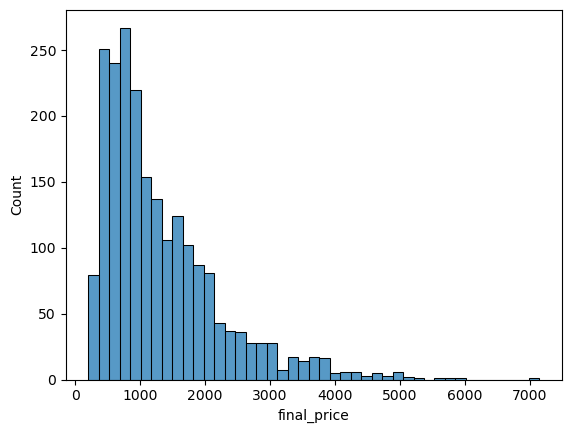

In [6]:
df = df_full[base]
sns.histplot(df['final_price'])
plt.show()

### Question 1
There's one column with missing values. What is it?

* 'ram'
* 'storage'
* 'screen'
* 'final_price'

In [7]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

### Question 2
What's the median (50% percentile) for variable 'ram'?

* 8
* 16
* 24
* 32

In [8]:
df['ram'].describe()

count    2160.000000
mean       15.413889
std         9.867815
min         4.000000
25%         8.000000
50%        16.000000
75%        16.000000
max       128.000000
Name: ram, dtype: float64

### Question 3
Prepare and split the dataset

Shuffle the dataset (the filtered one you created above), use seed 42.

Split your data in train/val/test sets, with 60%/20%/20% distribution.

Use the same code as in the lectures

We need to deal with missing values for the column from Q1.

We have two options: fill it with 0 or with the mean of this variable.

Try both options. For each, train a linear regression model without regularization using the code from the lessons.

For computing the mean, use the training only!

Use the validation dataset to evaluate the models and compare the RMSE of each option.

Round the RMSE scores to 2 decimal digits using round(score, 2)

Which option gives better RMSE?
Options:

* With 0
* With mean
* Both are equally good

In [9]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [10]:
def prepare_X_fillzero(df):
    df_num = df.copy()
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [11]:
def prepare_X_fillmean(df, col, col_mean):
    df_num = df.copy()
    df_num[col] = df_num[col].fillna(col_mean)
    X = df_num.values
    return X

In [12]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return round(np.sqrt(mse),2)

In [13]:
def train_test_split(df, seed):
    np.random.seed(seed)
    
    n = len(df)
    
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)
    
    idx = np.arange(n)
    np.random.shuffle(idx)
    
    df_shuffled = df.iloc[idx]
    
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    # y_train_orig = df_train.final_price.values
    # y_val_orig = df_val.final_price.values
    # y_test_orig = df_test.final_price.values
    
    # y_train = np.log1p(df_train.final_price.values)
    # y_val = np.log1p(df_val.final_price.values)
    # y_test = np.log1p(df_test.final_price.values)

    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values
    
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    return df_train, y_train, df_val, y_val, df_test, y_test

In [14]:
df_train, y_train, df_val, y_val, _, _ = train_test_split(df, 42)

In [15]:
## Fill missing value with zero
X_train = prepare_X_fillzero(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X_fillzero(df_val)
y_pred = w_0 + X_val@w

rmse_zero = rmse(y_val, y_pred)
print(f"RMSE for filling with zero: {rmse_zero}")

RMSE for filling with zero: 597.36


In [16]:
## Fill missing value with mean
col = 'screen'
X_train = prepare_X_fillmean(df_train, col, df_train[col].mean())
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X_fillmean(df_val, col, df_train[col].mean())
y_pred = w_0 + X_val@w

rmse_mean = rmse(y_val, y_pred)
print(f"RMSE for filling with mean: {rmse_mean}")

RMSE for filling with mean: 600.27


### Question 4
Now let's train a regularized linear regression.

For this question, fill the NAs with 0.

Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].

Use RMSE to evaluate the model on the validation dataset.

Round the RMSE scores to 2 decimal digits.

Which r gives the best RMSE?
If there are multiple options, select the smallest r.

Options:

* 0
* 0.01
* 1
* 10
* 100

In [17]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [18]:
## Fill missing value with zero
X_train = prepare_X_fillzero(df_train)
X_val = prepare_X_fillzero(df_val)

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r)
    y_pred = w_0 + X_val@w

    print(f"RMSE for r={r}:\t {rmse(y_val, y_pred)}")

RMSE for r=0:	 597.36
RMSE for r=0.01:	 597.36
RMSE for r=0.1:	 597.35
RMSE for r=1:	 597.21
RMSE for r=5:	 597.01
RMSE for r=10:	 597.06
RMSE for r=100:	 597.9


### Question 5
We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.

Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].

For each seed, do the train/validation/test split with 60%/20%/20% distribution.

Fill the missing values with 0 and train a model without regularization.

For each seed, evaluate the model on the validation dataset and collect the RMSE scores.

What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
Round the result to 3 decimal digits (round(std, 3))
What's the value of std?

* 19.176
* 29.176
* 39.176
* 49.176

Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.


In [19]:
def question_5(df, seed):
    df_train, y_train, df_val, y_val, _, _ = train_test_split(df, seed)
    X_train = prepare_X_fillzero(df_train)
    w_0, w = train_linear_regression(X_train, y_train)
    
    X_val = prepare_X_fillzero(df_val)
    y_pred = w_0 + X_val@w  
    return rmse(y_val, y_pred)

In [20]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_list = [question_5(df, seed) for seed in seeds]

In [21]:
print(rmse_list)

[565.45, 636.8, 588.96, 597.81, 571.96, 573.24, 647.34, 550.44, 587.33, 576.1]


In [22]:
round(np.std(rmse_list), 3)

29.176

### Question 6
Split the dataset like previously, use seed 9.

Combine train and validation datasets.

Fill the missing values with 0 and train a model with r=0.001.

What's the RMSE on the test dataset?
Options:

* 598.60
* 608.60
* 618.60
* 628.60

In [24]:
df_train, y_train, df_val, y_val, df_test, y_test = train_test_split(df, 9)
X_train = prepare_X_fillzero(df_train)
X_val = prepare_X_fillzero(df_val)
X_test = prepare_X_fillzero(df_test)

X_combine = np.concatenate((X_train, X_val), axis=0) #pd.concat([X_train, X_val])
y_combine = np.concatenate((y_train, y_val), axis=0)
w_0, w = train_linear_regression_reg(X_combine, y_combine, 0.001)

y_pred = w_0 + X_test@w  
print(rmse(y_test, y_pred))

608.61
